In [2]:
import numpy as np
import sklearn as sk
from tensorflow import keras
import pandas as pd
import scipy
import tensorflow as tf

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow_docs as tfdocs
np.set_printoptions(suppress=True)
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import regularizers, layers

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline
pd.set_option('display.max_columns', 150)

In [3]:
data_un = pd.read_csv('train_data.csv', sep = ',')

In [4]:
data_un.head()

,Unnamed: 0,id_policy,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,commune_code,canton_code,city_district_code,regional_department_code,claim_amount,made_claim
0,0,A00013211-V01,0.5,Maxi,36,6,Biannual,No,Retired,68269,No,77,0,M,NaN,55,0,15,1598,111,Gasoline,RENAULT,SCENIC,16,15,185,Tourism,17517,1260,526.0,3216.0,4.8,269.0,20.0,5.0,68,0.0,0
1,1,A00040885-V01,0.5,Maxi,15,5,Yearly,No,WorkPrivate,29019,Yes,52,55,M,F,33,35,12,2184,112,Diesel,NISSAN,ALMERA TINO,12,9,180,Tourism,21500,1480,57.0,4912.0,141.3,19.0,99.0,1.0,29,0.0,0
2,2,A00044495-V01,0.5,Mini,16,6,Monthly,No,Professional,13080,No,52,0,M,NaN,34,0,20,2496,112,Diesel,LAND ROVER,DEFENDER,32,19,130,Commercial,23600,2931,257.0,4488.0,5.3,80.0,27.0,1.0,13,0.0,0
3,3,A00047266-V01,0.5,Maxi,11,7,Biannual,No,WorkPrivate,10387,No,67,0,M,NaN,46,0,12,1149,75,Gasoline,RENAULT,CLIO,14,12,170,Tourism,13050,930,109.0,1339.0,61.2,387.0,99.0,3.0,10,0.0,0
4,4,A00074532-V01,0.5,Median2,16,6,Biannual,No,WorkPrivate,59153,Yes,60,37,M,F,35,14,23,1905,93,Diesel,CITROEN,ZX,23,18,185,Tourism,17974,1035,24.0,1849.0,9.7,153.0,19.0,6.0,59,0.0,0


In [5]:
columns_x = ['pol_bonus', 'pol_coverage', 'pol_duration',
                   'pol_sit_duration', 'pol_pay_freq', 'pol_payd', 'pol_usage', 
                   'drv_drv2', 'drv_age1', 'drv_age2', 'drv_sex1',
                   'drv_sex2', 'drv_age_lic1', 'drv_age_lic2', 'vh_age', 'vh_cyl',
                   'vh_din', 'vh_fuel', 'vh_make', 'vh_sale_begin',
                   'vh_sale_end', 'vh_speed', 'vh_type', 'vh_value', 'vh_weight',
                   'town_mean_altitude', 'town_surface_area', 'population', 'city_district_code',
                  ]

In [6]:
#need to check exactly how these are loaded.
x_data_un = data_un[columns_x]
y_data = data_un.claim_amount

In [7]:
cat_to_int_dict = {'pol_coverage': {'Mini':0, 'Median1':1, 'Median2':2, 'Maxi':3},
                           'pol_pay_freq': {'Monthly':0, 'Quarterly':1, 'Biannual':2, 'Yearly':3},
                           'pol_payd': {'No':0, 'Yes':1},
                           'pol_usage': {'Retired':0, 'WorkPrivate':1, 'Professional':2, 'AllTrips':3},
                           'drv_drv2': {'No':0, 'Yes':1},
                           'drv_sex1': {'F':0, 'M':1},
                           'drv_sex2': {'F':-1, 'M':1, None:0},
                           'vh_type': {'Tourism':0, 'Commercial':1,}
                           }



def car_make_categories(car_make):
    if car_make in ['RENAULT','PEUGEOT','CITROEN','VOLKSWAGEN','FORD', 'MERCEDES BENZ']:
        return car_make
    else:
        return 'OTHER'
    
def missing_geo_data(x):
    if x:
        return 1
    else:
        return 0
    
def zero_vh_weight(weight, avg_weight):
    if weight<100:
        return avg_weight
    else:
        return weight

    
x_data_f = x_data_un.replace(cat_to_int_dict, inplace=False)

In [8]:
x_data_f.vh_make = x_data_f['vh_make'].apply(lambda x: car_make_categories(x))

##MAKE INDEP
avg_vh_weight = x_data_f['vh_weight'].mean()
x_data_f.vh_weight = x_data_f['vh_weight'].apply(lambda x: zero_vh_weight(x, avg_vh_weight))


vh_make_cols = pd.get_dummies(x_data_f.vh_make)
vh_fuel_cols= pd.get_dummies(x_data_f.vh_fuel)
city_dist_cols= pd.get_dummies(x_data_f.city_district_code)
x_data_f = x_data_f.drop(['vh_fuel', 'vh_make', 'city_district_code'], axis = 1)

x_data_f['geoNA'] = (x_data_un['population'].isnull()).apply(lambda x: missing_geo_data(x))


x_data_f = pd.concat([x_data_f, vh_make_cols, vh_fuel_cols, city_dist_cols], axis=1, sort=False)


In [9]:
x_data_f.head()

,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,geoNA,CITROEN,FORD,MERCEDES BENZ,OTHER,PEUGEOT,RENAULT,VOLKSWAGEN,Diesel,Gasoline,Hybrid,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,0.5,3,36,6,2,0,0,0,77,0,1,0,55,0,15,1598,111,16,15,185,0,17517,1260.0,526.0,3216.0,4.8,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0.5,3,15,5,3,0,1,1,52,55,1,-1,33,35,12,2184,112,12,9,180,0,21500,1480.0,57.0,4912.0,141.3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,0.5,0,16,6,0,0,2,0,52,0,1,0,34,0,20,2496,112,32,19,130,1,23600,2931.0,257.0,4488.0,5.3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0.5,3,11,7,2,0,1,0,67,0,1,0,46,0,12,1149,75,14,12,170,0,13050,930.0,109.0,1339.0,61.2,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,0.5,2,16,6,2,0,1,1,60,37,1,-1,35,14,23,1905,93,23,18,185,0,17974,1035.0,24.0,1849.0,9.7,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [10]:
MEANS = x_data_f.mean()
x_data_f = x_data_f.fillna(MEANS)

In [11]:
x_data_f.dtypes

pol_bonus             float64
pol_coverage            int64
pol_duration            int64
pol_sit_duration        int64
pol_pay_freq            int64
pol_payd                int64
pol_usage               int64
drv_drv2                int64
drv_age1                int64
drv_age2                int64
drv_sex1                int64
drv_sex2                int64
drv_age_lic1            int64
drv_age_lic2            int64
vh_age                  int64
vh_cyl                  int64
vh_din                  int64
vh_sale_begin           int64
vh_sale_end             int64
vh_speed                int64
vh_type                 int64
vh_value                int64
vh_weight             float64
town_mean_altitude    float64
town_surface_area     float64
population            float64
geoNA                   int64
CITROEN                 uint8
FORD                    uint8
MERCEDES BENZ           uint8
OTHER                   uint8
PEUGEOT                 uint8
RENAULT                 uint8
VOLKSWAGEN

In [12]:

scaler = preprocessing.MinMaxScaler()
x_data = pd.DataFrame(scaler.fit_transform(x_data_f), columns=x_data_f.columns, index=x_data_f.index)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

In [42]:
[x_train.shape[1]]

[46]

In [37]:
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def build_relu10_relu5_relu5_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_relu15_relu10_relu5_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_tanh10_relu10_relu10_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_tanh10_tanh10_tanh10_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='tanh'),
    layers.Dense(10, activation='tanh'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm10_relu5_relu5_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_relu5_relu5_relu5_relu5_lin():
  model = keras.Sequential([
    layers.Dense(5, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_relu10_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm10_sign5_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(5, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm10_sign5_sigm5_lin():
  model = keras.Sequential([
    layers.Dense(10, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(5, activation='sigmoid'),
    layers.Dense(5, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm15_relu10_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm20_relu15_sigm15_lin():
  model = keras.Sequential([
    layers.Dense(20, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(15, activation='relu'),
    layers.Dense(15, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_sigm15_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm15_relu10_relu10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_lin():
  model = keras.Sequential([
    layers.Dense(1, input_shape=[x_train.shape[1]]),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [43]:
def build_sigm15_relu10_tanh10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='tanh'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_tanh15_relu10_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='tanh', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm15_tanh10_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(15, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='tanh'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_sigm30_relu10_sigm10_lin():
  model = keras.Sequential([
    layers.Dense(30, activation='sigmoid', input_shape=[x_train.shape[1]]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='sigmoid'),
    layers.Dense(1)
  ])

  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
def train_model(model, X_train, y_train, epochs = 1000):

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, 
                        epochs=epochs, validation_split = 0.2, verbose=1, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    return model, history


plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

def plot_stats(hist, stat):
    #plt.plot(hist.history[stat])
    plt.plot(hist.history['val_'+stat])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def test_model(model, X_data, y_data):
    predictions = model.predict(X_data).reshape(X_data.shape[0])
    return (np.abs(predictions - y_data)).sum()

In [16]:
def run_whole_model_assesment(model, X_train = x_train, X_test = x_test, y_train = y_train, y_test = y_test):
    try:
        model, history = train_model(model, X_train, y_train)
        print('TRAINING ENDED')
    except:
        print('failed training')
    #try:
    #    plotter.plot({'Basic': history}, metric = "mse")
    #except:
    #    print('failed graph printing')
    try:
        plot_stats(history, 'mse')
    except:
        print('failed to print graph - not that its that good anyway')
    print('-------------------------------------------------------------------------------')
    print('/n')
    print('Strategy net profitability')
    try:
        print(test_model(model, X_test, y_test))
    except:
        print('failed to test the model')
    print('-------------------------------------------------------------------------------')
    print('/n')
    print('the first few reults of our predictions - to check they arent identical')
    try:
        print(model.predict(X_test)[:10])
    except:
        print('failed to make a few quick predictions')

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36064/36400 [============================>.] - ETA: 0s - loss: 337619.3591 - mae: 114.3734 - mse: 337619.3750
Epoch: 0, loss:335668.6225,  mae:113.9994,  mse:335668.6250,  val_loss:291935.5807,  val_mae:122.4070,  val_mse:291935.4688,  
36400/36400 [==============================] - 8s 209us/sample - loss: 335668.6225 - mae: 113.9994 - mse: 335668.6250 - val_loss: 291935.5807 - val_mae: 122.4070 - val_mse: 291935.4688
Epoch 2/1000
36400/36400 [==============================] - 8s 210us/sample - loss: 333735.0551 - mae: 121.8856 - mse: 333735.0000 - val_loss: 290252.6332 - val_mae: 129.7000 - val_mse: 290252.5625
Epoch 3/1000
36400/36400 [==============================] - 9s 239us/sample - loss: 332334.8253 - mae: 128.6275 - mse: 332334.6562 - val_loss: 288944.1908 - val_mae: 135.9174 - val_mse: 288944.2500
Epoch 4/1000
36400/36400 [==============================] - 8s 233us/sample - loss: 331160.4502 - mae: 134.7487 - mse: 3

36400/36400 [==============================] - 8s 207us/sample - loss: 322198.9273 - mae: 181.5812 - mse: 322198.9688 - val_loss: 279063.5116 - val_mae: 182.0210 - val_mse: 279063.5312
Epoch 40/1000
36400/36400 [==============================] - 7s 181us/sample - loss: 322137.4250 - mae: 182.1084 - mse: 322137.5000 - val_loss: 278948.3947 - val_mae: 184.3468 - val_mse: 278948.3750
Epoch 41/1000
36400/36400 [==============================] - 8s 218us/sample - loss: 322084.4670 - mae: 182.2024 - mse: 322084.6562 - val_loss: 279002.9811 - val_mae: 183.0363 - val_mse: 279002.9375
Epoch 42/1000
36400/36400 [==============================] - 8s 214us/sample - loss: 322019.1064 - mae: 181.8103 - mse: 322019.0312 - val_loss: 278861.6209 - val_mae: 196.5267 - val_mse: 278861.5938
Epoch 43/1000
36400/36400 [==============================] - 7s 186us/sample - loss: 321969.5259 - mae: 183.0172 - mse: 321969.4062 - val_loss: 278786.5325 - val_mae: 192.4655 - val_mse: 278786.5000
Epoch 44/1000
36400

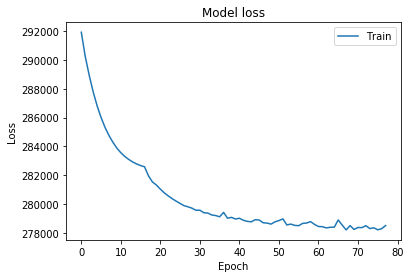

-------------------------------------------------------------------------------
/n
Strategy net profitability
3821821.2060862733
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 35.928318]
 [ 19.01169 ]
 [188.5556  ]
 [196.75    ]
 [197.37418 ]
 [ 72.22055 ]
 [ 20.376259]
 [125.526375]
 [122.68277 ]
 [ 67.672134]]


In [45]:
run_whole_model_assesment(build_sigm15_relu10_tanh10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36096/36400 [============================>.] - ETA: 0s - loss: 336859.5115 - mae: 111.0782 - mse: 336859.2188
Epoch: 0, loss:336318.0317,  mae:111.1958,  mse:336317.7188,  val_loss:293085.3617,  val_mae:117.7825,  val_mse:293085.3438,  
36400/36400 [==============================] - 6s 158us/sample - loss: 336318.0317 - mae: 111.1958 - mse: 336317.7188 - val_loss: 293085.3617 - val_mae: 117.7825 - val_mse: 293085.3438
Epoch 2/1000
36400/36400 [==============================] - 7s 179us/sample - loss: 335114.2947 - mae: 116.0087 - mse: 335114.3125 - val_loss: 291936.7736 - val_mae: 122.4024 - val_mse: 291936.8750
Epoch 3/1000
36400/36400 [==============================] - 6s 173us/sample - loss: 334077.3018 - mae: 120.4422 - mse: 334077.5312 - val_loss: 290907.3575 - val_mae: 126.7797 - val_mse: 290907.3750
Epoch 4/1000
36400/36400 [==============================] - 9s 248us/sample - loss: 333150.7104 - mae: 124.7205 - mse: 3

Epoch 40/1000
36400/36400 [==============================] - 11s 302us/sample - loss: 323303.7656 - mae: 174.3411 - mse: 323303.8125 - val_loss: 280003.4011 - val_mae: 180.3298 - val_mse: 280003.4688
Epoch 41/1000
36400/36400 [==============================] - 10s 275us/sample - loss: 323235.8305 - mae: 175.4242 - mse: 323235.9688 - val_loss: 279913.2757 - val_mae: 179.5653 - val_mse: 279913.0938
Epoch 42/1000
36400/36400 [==============================] - 11s 296us/sample - loss: 323101.0074 - mae: 175.0652 - mse: 323100.6562 - val_loss: 279882.6105 - val_mae: 180.4217 - val_mse: 279882.5000
Epoch 43/1000
36400/36400 [==============================] - 11s 295us/sample - loss: 322995.9586 - mae: 175.1729 - mse: 322996.0000 - val_loss: 279720.3870 - val_mae: 185.3230 - val_mse: 279720.2812
Epoch 44/1000
36400/36400 [==============================] - 15s 413us/sample - loss: 322863.3620 - mae: 176.0402 - mse: 322863.5625 - val_loss: 279661.7911 - val_mae: 183.1787 - val_mse: 279661.8438


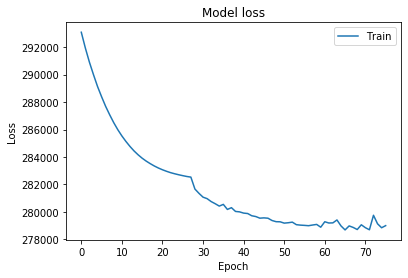

-------------------------------------------------------------------------------
/n
Strategy net profitability
3805798.655785675
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 38.33434 ]
 [ 20.287376]
 [167.45555 ]
 [168.85805 ]
 [168.85953 ]
 [ 81.76215 ]
 [ 24.739368]
 [115.2834  ]
 [142.5572  ]
 [ 65.558754]]


In [49]:
run_whole_model_assesment(build_tanh15_relu10_sigm10_lin())

In [50]:
run_whole_model_assesment(build_sigm15_tanh10_sigm10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36256/36400 [============================>.] - ETA: 0s - loss: 336416.0588 - mae: 111.6059 - mse: 336416.2812
Epoch: 0, loss:336173.0762,  mae:111.7641,  mse:336173.2500,  val_loss:292773.0747,  val_mae:119.0135,  val_mse:292773.0625,  
36400/36400 [==============================] - 2s 46us/sample - loss: 336173.0762 - mae: 111.7641 - mse: 336173.2500 - val_loss: 292773.0747 - val_mae: 119.0135 - val_mse: 292773.0625
Epoch 2/1000
36400/36400 [==============================] - 1s 36us/sample - loss: 334571.1385 - mae: 118.3152 - mse: 334571.3125 - val_loss: 291191.0415 - val_mae: 125.5488 - val_mse: 291191.0625
Epoch 3/1000
36400/36400 [==============================] - 1s 39us/sample - loss: 333257.7795 - mae: 124.2186 - mse: 333257.7188 - val_loss: 289955.1258 - val_mae: 131.0668 - val_mse: 289955.2188
Epoch 4/1000
36400/36400 [==============================] - 2s 47us/sample - loss: 332170.4610 - mae: 129.4946 - mse: 33217

In [51]:
run_whole_model_assesment(build_sigm30_relu10_sigm10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
20704/36400 [================>.............] - ETA: 2s - loss: 303839.6664 - mae: 111.4935 - mse: 303839.5312failed training
failed to print graph - not that its that good anyway
-------------------------------------------------------------------------------
/n
Strategy net profitability
2460357.404673271
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[6.104819 ]
 [6.1043158]
 [6.1062646]
 [6.105133 ]
 [6.1061172]
 [6.1054697]
 [6.1051135]
 [6.105486 ]
 [6.1032696]
 [6.1027994]]


In [ ]:
build_sigm15_relu10_tanh10_lin()  build_tanh15_relu10_sigm10_lin() build_sigm15_tanh10_sigm10_lin() build_sigm30_relu10_sigm10_lin()

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36288/36400 [============================>.] - ETA: 0s - loss: 331042.6099 - mae: 149.8283 - mse: 331042.2188
Epoch: 0, loss:330365.0089,  mae:149.9351,  mse:330364.6250,  val_loss:282280.2089,  val_mae:193.5125,  val_mse:282280.1875,  
36400/36400 [==============================] - 7s 190us/sample - loss: 330365.0089 - mae: 149.9351 - mse: 330364.6250 - val_loss: 282280.2089 - val_mae: 193.5125 - val_mse: 282280.1875
Epoch 2/1000
36400/36400 [==============================] - 7s 192us/sample - loss: 324397.1725 - mae: 187.6201 - mse: 324397.3750 - val_loss: 279683.3184 - val_mae: 196.9498 - val_mse: 279683.2812
Epoch 3/1000
36400/36400 [==============================] - 8s 214us/sample - loss: 322618.6171 - mae: 189.8237 - mse: 322618.3438 - val_loss: 278871.9906 - val_mae: 199.2811 - val_mse: 278871.9062
Epoch 4/1000
36400/36400 [==============================] - 7s 182us/sample - loss: 321995.3855 - mae: 190.4100 - mse: 3

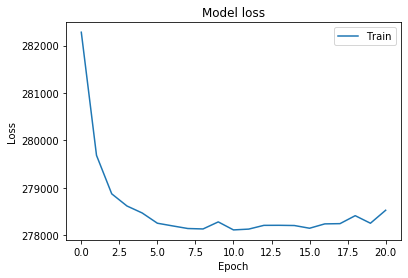

-------------------------------------------------------------------------------
/n
Strategy net profitability
3843416.1759981727
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 47.49157 ]
 [ 27.354902]
 [170.53287 ]
 [227.54427 ]
 [213.25578 ]
 [ 83.03412 ]
 [ 42.32258 ]
 [ 99.55205 ]
 [129.8522  ]
 [ 77.29759 ]]


In [31]:
run_whole_model_assesment(build_tanh10_relu10_relu10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
35168/36400 [===========================>..] - ETA: 0s - loss: 337724.6422 - mae: 109.8222 - mse: 337724.6875
Epoch: 0, loss:336526.0984,  mae:110.3340,  mse:336526.1250,  val_loss:293192.4332,  val_mae:117.2573,  val_mse:293192.4375,  
36400/36400 [==============================] - 1s 38us/sample - loss: 336526.0984 - mae: 110.3340 - mse: 336526.1250 - val_loss: 293192.4332 - val_mae: 117.2573 - val_mse: 293192.4375
Epoch 2/1000
36400/36400 [==============================] - 1s 32us/sample - loss: 335137.3633 - mae: 115.8646 - mse: 335137.2500 - val_loss: 291840.4085 - val_mae: 122.5879 - val_mse: 291840.2812
Epoch 3/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 333900.6789 - mae: 121.0835 - mse: 333900.5312 - val_loss: 290608.1547 - val_mae: 127.7673 - val_mse: 290607.9062
Epoch 4/1000
36400/36400 [==============================] - 1s 33us/sample - loss: 332778.7900 - mae: 126.1909 - mse: 33277

36400/36400 [==============================] - 1s 32us/sample - loss: 324791.0056 - mae: 190.4234 - mse: 324791.0000 - val_loss: 281420.0058 - val_mae: 194.9675 - val_mse: 281419.9688
Epoch 41/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 324763.5024 - mae: 190.8159 - mse: 324763.5938 - val_loss: 281393.4659 - val_mae: 195.2423 - val_mse: 281393.4375
Epoch 42/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 324736.5790 - mae: 190.9182 - mse: 324736.5000 - val_loss: 281368.0719 - val_mae: 195.4353 - val_mse: 281368.0938
Epoch 43/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 324710.1674 - mae: 191.1890 - mse: 324709.9062 - val_loss: 281343.1623 - val_mae: 195.6569 - val_mse: 281343.2500
Epoch 44/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 324684.4530 - mae: 191.4976 - mse: 324684.5312 - val_loss: 281319.2431 - val_mae: 195.8382 - val_mse: 281319.3125
Epoch 45/1000
36400/3640

36400/36400 [==============================] - 1s 31us/sample - loss: 323931.1814 - mae: 193.0205 - mse: 323931.1875 - val_loss: 280662.6548 - val_mae: 197.5858 - val_mse: 280662.6875
Epoch 82/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 323914.3467 - mae: 192.9881 - mse: 323914.2812 - val_loss: 280648.1556 - val_mae: 197.6011 - val_mse: 280648.1250
Epoch 83/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 323897.7447 - mae: 193.0267 - mse: 323897.5312 - val_loss: 280634.9873 - val_mae: 197.6148 - val_mse: 280635.0312
Epoch 84/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 323882.0897 - mae: 193.0745 - mse: 323881.6562 - val_loss: 280622.1753 - val_mae: 197.5891 - val_mse: 280622.1250
Epoch 85/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 323866.0957 - mae: 192.9874 - mse: 323866.0938 - val_loss: 280608.5177 - val_mae: 197.5850 - val_mse: 280608.4688
Epoch 86/1000
36400/3640

36400/36400 [==============================] - 1s 31us/sample - loss: 323378.3777 - mae: 192.7161 - mse: 323378.3125 - val_loss: 280203.8665 - val_mae: 197.5128 - val_mse: 280203.8125
Epoch 122/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 323367.0114 - mae: 192.8724 - mse: 323366.7188 - val_loss: 280194.6438 - val_mae: 197.5356 - val_mse: 280194.7812
Epoch 123/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 323355.9932 - mae: 192.7534 - mse: 323356.0000 - val_loss: 280185.4728 - val_mae: 197.5206 - val_mse: 280185.4375
Epoch 124/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 323344.8000 - mae: 192.8545 - mse: 323344.6875 - val_loss: 280176.2788 - val_mae: 197.5144 - val_mse: 280176.3438
Epoch 125/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 323333.6286 - mae: 192.7497 - mse: 323333.7500 - val_loss: 280167.2206 - val_mae: 197.5041 - val_mse: 280167.3125
Epoch 126/1000
36400

36400/36400 [==============================] - 1s 30us/sample - loss: 322984.6038 - mae: 192.5620 - mse: 322984.4062 - val_loss: 279881.8327 - val_mae: 197.4791 - val_mse: 279881.8750
Epoch 163/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 322976.4221 - mae: 192.6127 - mse: 322976.2812 - val_loss: 279875.3565 - val_mae: 197.4905 - val_mse: 279875.2812
Epoch 164/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 322968.5453 - mae: 192.5364 - mse: 322968.3750 - val_loss: 279868.6627 - val_mae: 197.4971 - val_mse: 279868.6875
Epoch 165/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 322960.7806 - mae: 192.7028 - mse: 322961.1250 - val_loss: 279862.8949 - val_mae: 197.4833 - val_mse: 279862.9062
Epoch 166/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 322953.0349 - mae: 192.5747 - mse: 322952.7188 - val_loss: 279856.3393 - val_mae: 197.4966 - val_mse: 279856.1250
Epoch 167/1000
36400

36400/36400 [==============================] - 1s 34us/sample - loss: 322710.7992 - mae: 192.7023 - mse: 322710.6562 - val_loss: 279661.1642 - val_mae: 197.6183 - val_mse: 279661.2812
Epoch 203/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 322705.1726 - mae: 192.5993 - mse: 322705.1562 - val_loss: 279655.9616 - val_mae: 197.6474 - val_mse: 279656.0625
Epoch 204/1000
36400/36400 [==============================] - 1s 32us/sample - loss: 322699.1286 - mae: 192.5473 - mse: 322698.8750 - val_loss: 279651.3227 - val_mae: 197.6341 - val_mse: 279651.2500
Epoch 205/1000
36400/36400 [==============================] - 1s 33us/sample - loss: 322693.1151 - mae: 192.7435 - mse: 322693.1875 - val_loss: 279646.7965 - val_mae: 197.6351 - val_mse: 279646.7812
Epoch 206/1000
36400/36400 [==============================] - 1s 33us/sample - loss: 322687.5506 - mae: 192.6863 - mse: 322687.2812 - val_loss: 279642.2889 - val_mae: 197.6505 - val_mse: 279642.2500
Epoch 207/1000
36400

36400/36400 [==============================] - 1s 30us/sample - loss: 322505.3604 - mae: 192.7866 - mse: 322505.1875 - val_loss: 279497.1233 - val_mae: 197.8397 - val_mse: 279497.0625
Epoch 244/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 322500.8830 - mae: 192.7972 - mse: 322500.9688 - val_loss: 279494.0053 - val_mae: 197.8219 - val_mse: 279494.0625
Epoch 245/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322496.6449 - mae: 192.7862 - mse: 322496.7812 - val_loss: 279490.2424 - val_mae: 197.8600 - val_mse: 279490.3438
Epoch 246/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322492.5779 - mae: 192.7465 - mse: 322492.5625 - val_loss: 279487.0259 - val_mae: 197.8546 - val_mse: 279487.1562
Epoch 247/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322488.3713 - mae: 192.7550 - mse: 322488.1875 - val_loss: 279483.7000 - val_mae: 197.8790 - val_mse: 279483.6562
Epoch 248/1000
36400

36400/36400 [==============================] - 1s 29us/sample - loss: 322352.4689 - mae: 193.0556 - mse: 322352.6250 - val_loss: 279377.7079 - val_mae: 198.0354 - val_mse: 279377.5625
Epoch 285/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322349.3120 - mae: 193.0130 - mse: 322349.4688 - val_loss: 279374.8623 - val_mae: 198.0575 - val_mse: 279374.8125
Epoch 286/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322345.8929 - mae: 193.0260 - mse: 322345.7188 - val_loss: 279372.1976 - val_mae: 198.0775 - val_mse: 279372.1875
Epoch 287/1000
36400/36400 [==============================] - 1s 28us/sample - loss: 322342.6113 - mae: 192.9913 - mse: 322342.5000 - val_loss: 279369.9061 - val_mae: 198.0699 - val_mse: 279369.8438
Epoch 288/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322339.6326 - mae: 192.8584 - mse: 322339.5312 - val_loss: 279367.0975 - val_mae: 198.0967 - val_mse: 279367.0312
Epoch 289/1000
36400

36400/36400 [==============================] - 1s 29us/sample - loss: 322236.8366 - mae: 193.2379 - mse: 322237.0938 - val_loss: 279286.7794 - val_mae: 198.3707 - val_mse: 279286.8125
Epoch 325/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322234.6550 - mae: 193.2389 - mse: 322234.5000 - val_loss: 279285.0795 - val_mae: 198.3538 - val_mse: 279285.0000
Epoch 326/1000
36400/36400 [==============================] - 1s 28us/sample - loss: 322231.9833 - mae: 193.4018 - mse: 322232.2812 - val_loss: 279283.0534 - val_mae: 198.3863 - val_mse: 279283.1562
Epoch 327/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 322229.5494 - mae: 193.3489 - mse: 322229.3125 - val_loss: 279281.7654 - val_mae: 198.3391 - val_mse: 279281.6562
Epoch 328/1000
36400/36400 [==============================] - 1s 28us/sample - loss: 322227.1236 - mae: 193.2404 - mse: 322227.0000 - val_loss: 279279.4206 - val_mae: 198.3694 - val_mse: 279279.4375
Epoch 329/1000
36400

36400/36400 [==============================] - 1s 28us/sample - loss: 322143.6049 - mae: 193.4211 - mse: 322143.5312 - val_loss: 279215.7577 - val_mae: 198.5750 - val_mse: 279215.6562
Epoch 366/1000
36400/36400 [==============================] - 1s 28us/sample - loss: 322141.4948 - mae: 193.4034 - mse: 322141.2812 - val_loss: 279214.1001 - val_mae: 198.5974 - val_mse: 279214.0938
Epoch 367/1000
36400/36400 [==============================] - 1s 26us/sample - loss: 322139.4746 - mae: 193.4641 - mse: 322139.4062 - val_loss: 279212.4808 - val_mae: 198.6122 - val_mse: 279212.3125
Epoch 368/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322137.6004 - mae: 193.5055 - mse: 322137.4688 - val_loss: 279211.0650 - val_mae: 198.6083 - val_mse: 279211.2188
Epoch 369/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322135.5668 - mae: 193.5129 - mse: 322135.4688 - val_loss: 279209.6204 - val_mae: 198.6097 - val_mse: 279209.7812
Epoch 370/1000
36400

36400/36400 [==============================] - 1s 27us/sample - loss: 322070.4359 - mae: 193.6379 - mse: 322070.2812 - val_loss: 279159.8599 - val_mae: 198.8629 - val_mse: 279159.9375
Epoch 406/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322068.7593 - mae: 193.7249 - mse: 322068.7188 - val_loss: 279158.8691 - val_mae: 198.8536 - val_mse: 279158.8438
Epoch 407/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322066.8098 - mae: 193.7775 - mse: 322067.0625 - val_loss: 279157.5953 - val_mae: 198.8605 - val_mse: 279157.5625
Epoch 408/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322065.7187 - mae: 193.6686 - mse: 322065.8750 - val_loss: 279156.1519 - val_mae: 198.8869 - val_mse: 279156.1562
Epoch 409/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 322063.5969 - mae: 193.7198 - mse: 322063.6562 - val_loss: 279154.9650 - val_mae: 198.8868 - val_mse: 279155.0312
Epoch 410/1000
36400

36400/36400 [==============================] - 1s 41us/sample - loss: 322008.7721 - mae: 193.8962 - mse: 322008.6875 - val_loss: 279114.5098 - val_mae: 199.0713 - val_mse: 279114.4062
Epoch 447/1000
36400/36400 [==============================] - 1s 37us/sample - loss: 322007.1732 - mae: 193.9495 - mse: 322007.1562 - val_loss: 279113.5555 - val_mae: 199.0759 - val_mse: 279113.5000
Epoch 448/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 322005.8846 - mae: 193.9275 - mse: 322005.8438 - val_loss: 279112.3843 - val_mae: 199.0950 - val_mse: 279112.3750
Epoch 449/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 322004.3616 - mae: 194.0143 - mse: 322004.6562 - val_loss: 279111.3289 - val_mae: 199.1070 - val_mse: 279111.1875
Epoch 450/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 322003.2579 - mae: 193.9582 - mse: 322003.1875 - val_loss: 279110.6873 - val_mae: 199.0853 - val_mse: 279110.6875
Epoch 451/1000
36400

36400/36400 [==============================] - 1s 27us/sample - loss: 321956.9917 - mae: 194.1460 - mse: 321957.1875 - val_loss: 279077.4634 - val_mae: 199.2247 - val_mse: 279077.4062
Epoch 488/1000
36400/36400 [==============================] - 1s 24us/sample - loss: 321955.6862 - mae: 194.1366 - mse: 321956.0000 - val_loss: 279076.6059 - val_mae: 199.2296 - val_mse: 279076.6562
Epoch 489/1000
36400/36400 [==============================] - 1s 24us/sample - loss: 321954.7755 - mae: 194.0221 - mse: 321954.8750 - val_loss: 279075.6920 - val_mae: 199.2403 - val_mse: 279075.6250
Epoch 490/1000
36400/36400 [==============================] - 1s 24us/sample - loss: 321953.6081 - mae: 194.1438 - mse: 321953.5312 - val_loss: 279074.8258 - val_mae: 199.2528 - val_mse: 279074.8750
Epoch 491/1000
36400/36400 [==============================] - 1s 27us/sample - loss: 321952.4321 - mae: 194.1688 - mse: 321952.5000 - val_loss: 279074.2454 - val_mae: 199.2355 - val_mse: 279074.1875
Epoch 492/1000
36400

36400/36400 [==============================] - 1s 26us/sample - loss: 321914.1948 - mae: 194.2762 - mse: 321914.0312 - val_loss: 279046.9738 - val_mae: 199.4300 - val_mse: 279047.0625
Epoch 528/1000
36400/36400 [==============================] - 2s 42us/sample - loss: 321913.0845 - mae: 194.3241 - mse: 321913.0000 - val_loss: 279046.6652 - val_mae: 199.4132 - val_mse: 279046.4688
Epoch 529/1000
36400/36400 [==============================] - 1s 37us/sample - loss: 321912.0293 - mae: 194.3484 - mse: 321911.9688 - val_loss: 279045.3656 - val_mae: 199.4750 - val_mse: 279045.4375
Epoch 530/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321911.2168 - mae: 194.2738 - mse: 321911.1562 - val_loss: 279044.9739 - val_mae: 199.4495 - val_mse: 279044.8125
Epoch 531/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 321910.1021 - mae: 194.3604 - mse: 321910.2812 - val_loss: 279044.3078 - val_mae: 199.4545 - val_mse: 279044.3750
Epoch 532/1000
36400

36400/36400 [==============================] - 1s 30us/sample - loss: 321876.1498 - mae: 194.4557 - mse: 321876.4062 - val_loss: 279021.4999 - val_mae: 199.5487 - val_mse: 279021.4688
Epoch 569/1000
36400/36400 [==============================] - 1s 41us/sample - loss: 321875.4149 - mae: 194.4798 - mse: 321875.1875 - val_loss: 279021.1474 - val_mae: 199.5333 - val_mse: 279021.0938
Epoch 570/1000
36400/36400 [==============================] - 2s 41us/sample - loss: 321874.7952 - mae: 194.3336 - mse: 321874.9062 - val_loss: 279020.3638 - val_mae: 199.5567 - val_mse: 279020.2188
Epoch 571/1000
36400/36400 [==============================] - 1s 36us/sample - loss: 321873.8829 - mae: 194.4879 - mse: 321873.5000 - val_loss: 279020.1085 - val_mae: 199.5349 - val_mse: 279020.2500
Epoch 572/1000
36400/36400 [==============================] - 1s 39us/sample - loss: 321872.9484 - mae: 194.3926 - mse: 321872.7188 - val_loss: 279019.4543 - val_mae: 199.5387 - val_mse: 279019.4688
Epoch 573/1000
36400

36400/36400 [==============================] - 1s 30us/sample - loss: 321843.9966 - mae: 194.6021 - mse: 321843.8750 - val_loss: 279000.1799 - val_mae: 199.6891 - val_mse: 279000.1875
Epoch 609/1000
36400/36400 [==============================] - 1s 39us/sample - loss: 321843.3821 - mae: 194.6291 - mse: 321843.4375 - val_loss: 278999.5997 - val_mae: 199.7026 - val_mse: 278999.6562
Epoch 610/1000
36400/36400 [==============================] - 1s 35us/sample - loss: 321842.8097 - mae: 194.5648 - mse: 321842.8750 - val_loss: 278999.2308 - val_mae: 199.6979 - val_mse: 278999.0000
Epoch 611/1000
36400/36400 [==============================] - 1s 36us/sample - loss: 321841.6861 - mae: 194.7157 - mse: 321841.5000 - val_loss: 278998.7378 - val_mae: 199.7031 - val_mse: 278998.6875
Epoch 612/1000
36400/36400 [==============================] - 2s 51us/sample - loss: 321841.1366 - mae: 194.5568 - mse: 321841.4375 - val_loss: 278998.5055 - val_mae: 199.6830 - val_mse: 278998.4688
Epoch 613/1000
36400

36400/36400 [==============================] - 2s 44us/sample - loss: 321814.9815 - mae: 194.7577 - mse: 321815.2188 - val_loss: 278982.1751 - val_mae: 199.7948 - val_mse: 278982.1875
Epoch 650/1000
36400/36400 [==============================] - 2s 43us/sample - loss: 321814.4022 - mae: 194.6918 - mse: 321814.2500 - val_loss: 278981.7810 - val_mae: 199.8005 - val_mse: 278981.9375
Epoch 651/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321813.7096 - mae: 194.6208 - mse: 321814.0938 - val_loss: 278981.3577 - val_mae: 199.8029 - val_mse: 278981.4062
Epoch 652/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321813.1413 - mae: 194.6286 - mse: 321813.1875 - val_loss: 278981.0265 - val_mae: 199.7948 - val_mse: 278981.0000
Epoch 653/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321812.4494 - mae: 194.5717 - mse: 321812.5625 - val_loss: 278980.2230 - val_mae: 199.8393 - val_mse: 278980.2500
Epoch 654/1000
36400

36400/36400 [==============================] - 2s 44us/sample - loss: 321789.0184 - mae: 194.8229 - mse: 321789.1562 - val_loss: 278966.5768 - val_mae: 199.9038 - val_mse: 278966.5625
Epoch 691/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321788.4914 - mae: 194.7492 - mse: 321788.3125 - val_loss: 278965.9503 - val_mae: 199.9351 - val_mse: 278965.9062
Epoch 692/1000
36400/36400 [==============================] - 2s 43us/sample - loss: 321787.8425 - mae: 194.7490 - mse: 321787.8438 - val_loss: 278965.6860 - val_mae: 199.9264 - val_mse: 278965.5938
Epoch 693/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321787.3016 - mae: 194.7869 - mse: 321787.5625 - val_loss: 278965.1853 - val_mae: 199.9471 - val_mse: 278965.1562
Epoch 694/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321786.3467 - mae: 194.8664 - mse: 321786.2188 - val_loss: 278964.8215 - val_mae: 199.9536 - val_mse: 278964.9688
Epoch 695/1000
36400

36400/36400 [==============================] - 2s 44us/sample - loss: 321765.8507 - mae: 194.9268 - mse: 321766.1875 - val_loss: 278953.0697 - val_mae: 200.0134 - val_mse: 278953.0938
Epoch 731/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321765.8609 - mae: 194.8178 - mse: 321765.7500 - val_loss: 278953.1010 - val_mae: 199.9844 - val_mse: 278953.1250
Epoch 732/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321764.9365 - mae: 194.9131 - mse: 321765.0625 - val_loss: 278952.5449 - val_mae: 200.0235 - val_mse: 278952.4688
Epoch 733/1000
36400/36400 [==============================] - 2s 43us/sample - loss: 321764.5666 - mae: 194.9195 - mse: 321764.8125 - val_loss: 278951.9696 - val_mae: 200.0468 - val_mse: 278951.9375
Epoch 734/1000
36400/36400 [==============================] - 2s 44us/sample - loss: 321763.8920 - mae: 194.9267 - mse: 321764.0000 - val_loss: 278952.0627 - val_mae: 200.0095 - val_mse: 278952.1250
Epoch 735/1000
36400

36400/36400 [==============================] - 1s 33us/sample - loss: 321744.9967 - mae: 195.0394 - mse: 321744.7812 - val_loss: 278941.2333 - val_mae: 200.1030 - val_mse: 278941.2500
Epoch 772/1000
36400/36400 [==============================] - 1s 33us/sample - loss: 321744.5213 - mae: 194.9551 - mse: 321744.3750 - val_loss: 278941.2481 - val_mae: 200.0751 - val_mse: 278941.2188
Epoch 773/1000
36400/36400 [==============================] - 1s 32us/sample - loss: 321743.8818 - mae: 195.0101 - mse: 321744.0000 - val_loss: 278940.7602 - val_mae: 200.1030 - val_mse: 278940.9062
Epoch 774/1000
36400/36400 [==============================] - 1s 33us/sample - loss: 321743.4504 - mae: 195.0541 - mse: 321743.8438 - val_loss: 278940.6107 - val_mae: 200.0920 - val_mse: 278940.5938
Epoch 775/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 321742.9744 - mae: 194.9204 - mse: 321743.2500 - val_loss: 278940.5531 - val_mae: 200.0737 - val_mse: 278940.5938
Epoch 776/1000
36400

36400/36400 [==============================] - 2s 48us/sample - loss: 321726.2466 - mae: 195.0775 - mse: 321726.4062 - val_loss: 278931.0536 - val_mae: 200.1616 - val_mse: 278931.0312
Epoch 812/1000
36400/36400 [==============================] - 1s 38us/sample - loss: 321725.6244 - mae: 195.0926 - mse: 321725.5938 - val_loss: 278930.7194 - val_mae: 200.1714 - val_mse: 278930.7812
Epoch 813/1000
36400/36400 [==============================] - 1s 37us/sample - loss: 321725.1869 - mae: 195.0623 - mse: 321725.1562 - val_loss: 278930.7961 - val_mae: 200.1490 - val_mse: 278930.7812
Epoch 814/1000
36400/36400 [==============================] - 1s 37us/sample - loss: 321724.6791 - mae: 195.0823 - mse: 321724.7500 - val_loss: 278930.4796 - val_mae: 200.1569 - val_mse: 278930.4688
Epoch 815/1000
36400/36400 [==============================] - 1s 37us/sample - loss: 321724.2887 - mae: 194.9918 - mse: 321724.0312 - val_loss: 278930.3861 - val_mae: 200.1471 - val_mse: 278930.2812
Epoch 816/1000
36400

36400/36400 [==============================] - 2s 47us/sample - loss: 321708.3193 - mae: 195.1637 - mse: 321708.0938 - val_loss: 278922.2610 - val_mae: 200.2452 - val_mse: 278922.2188
Epoch 853/1000
36400/36400 [==============================] - 2s 47us/sample - loss: 321707.8397 - mae: 195.0345 - mse: 321707.9062 - val_loss: 278922.1705 - val_mae: 200.2375 - val_mse: 278922.1875
Epoch 854/1000
36400/36400 [==============================] - 2s 48us/sample - loss: 321707.3503 - mae: 195.2723 - mse: 321707.4375 - val_loss: 278921.9156 - val_mae: 200.2475 - val_mse: 278921.9375
Epoch 855/1000
36400/36400 [==============================] - 2s 48us/sample - loss: 321707.1897 - mae: 195.1357 - mse: 321707.3750 - val_loss: 278921.7306 - val_mae: 200.2447 - val_mse: 278921.7188
Epoch 856/1000
36400/36400 [==============================] - 2s 49us/sample - loss: 321706.6635 - mae: 195.1356 - mse: 321706.5625 - val_loss: 278921.6709 - val_mae: 200.2258 - val_mse: 278921.5938
Epoch 857/1000
36400

36400/36400 [==============================] - 1s 25us/sample - loss: 321692.0889 - mae: 195.1776 - mse: 321691.8750 - val_loss: 278914.5645 - val_mae: 200.2830 - val_mse: 278914.4062
Epoch 894/1000
36400/36400 [==============================] - 1s 26us/sample - loss: 321691.6795 - mae: 195.0910 - mse: 321691.8750 - val_loss: 278914.3574 - val_mae: 200.2880 - val_mse: 278914.4375
Epoch 895/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 321691.5234 - mae: 195.2061 - mse: 321691.4375 - val_loss: 278914.0080 - val_mae: 200.2929 - val_mse: 278913.8438
Epoch 896/1000
36400/36400 [==============================] - 1s 29us/sample - loss: 321691.1359 - mae: 195.0712 - mse: 321691.1875 - val_loss: 278913.8359 - val_mae: 200.2975 - val_mse: 278913.6875
Epoch 897/1000
36400/36400 [==============================] - 1s 28us/sample - loss: 321690.6076 - mae: 195.0957 - mse: 321690.4688 - val_loss: 278913.7075 - val_mae: 200.2920 - val_mse: 278913.6250
Epoch 898/1000
36400

36400/36400 [==============================] - 1s 26us/sample - loss: 321677.3595 - mae: 195.1862 - mse: 321677.2500 - val_loss: 278907.7347 - val_mae: 200.3440 - val_mse: 278907.8438
Epoch 934/1000
36400/36400 [==============================] - 1s 26us/sample - loss: 321677.1263 - mae: 195.2197 - mse: 321676.9062 - val_loss: 278907.3749 - val_mae: 200.3730 - val_mse: 278907.4062
Epoch 935/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 321676.6016 - mae: 195.2490 - mse: 321676.4688 - val_loss: 278907.1715 - val_mae: 200.3821 - val_mse: 278907.1250
Epoch 936/1000
36400/36400 [==============================] - 1s 26us/sample - loss: 321676.3995 - mae: 195.1945 - mse: 321676.3438 - val_loss: 278907.0874 - val_mae: 200.3786 - val_mse: 278907.1562
Epoch 937/1000
36400/36400 [==============================] - 1s 25us/sample - loss: 321676.1052 - mae: 195.1502 - mse: 321675.7500 - val_loss: 278906.9908 - val_mae: 200.3741 - val_mse: 278907.0625
Epoch 938/1000
36400

36400/36400 [==============================] - 1s 31us/sample - loss: 321663.2461 - mae: 195.3546 - mse: 321663.2812 - val_loss: 278901.7562 - val_mae: 200.4089 - val_mse: 278901.7188
Epoch 975/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 321663.0259 - mae: 195.2814 - mse: 321662.7188 - val_loss: 278901.8632 - val_mae: 200.3750 - val_mse: 278901.7500
Epoch 976/1000
36400/36400 [==============================] - 1s 30us/sample - loss: 321662.6633 - mae: 195.2843 - mse: 321662.9375 - val_loss: 278901.6475 - val_mae: 200.3984 - val_mse: 278901.5312
Epoch 977/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 321662.4973 - mae: 195.2245 - mse: 321662.5312 - val_loss: 278901.4712 - val_mae: 200.4002 - val_mse: 278901.4062
Epoch 978/1000
36400/36400 [==============================] - 1s 31us/sample - loss: 321661.9473 - mae: 195.2099 - mse: 321661.8125 - val_loss: 278901.4126 - val_mae: 200.3941 - val_mse: 278901.4688
Epoch 979/1000
36400

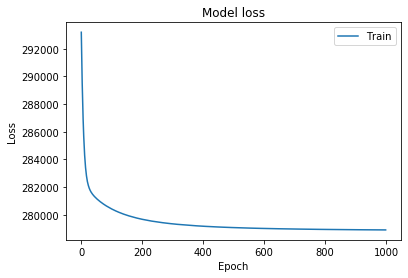

-------------------------------------------------------------------------------
/n
Strategy net profitability
4100123.6239526747
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 93.60246 ]
 [-11.1409  ]
 [169.6403  ]
 [172.11072 ]
 [192.58466 ]
 [118.226776]
 [ 37.30465 ]
 [118.60152 ]
 [144.85492 ]
 [103.485825]]


In [26]:
run_whole_model_assesment(build_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36160/36400 [============================>.] - ETA: 0s - loss: 336733.5028 - mae: 110.3730 - mse: 336733.5000
Epoch: 0, loss:336471.4130,  mae:110.4611,  mse:336471.4375,  val_loss:293433.1813,  val_mae:116.4319,  val_mse:293433.3125,  
36400/36400 [==============================] - 2s 47us/sample - loss: 336471.4130 - mae: 110.4611 - mse: 336471.4375 - val_loss: 293433.1813 - val_mae: 116.4319 - val_mse: 293433.3125
Epoch 2/1000
36400/36400 [==============================] - 1s 39us/sample - loss: 335681.0457 - mae: 113.6711 - mse: 335680.9062 - val_loss: 292745.1963 - val_mae: 119.1242 - val_mse: 292745.2500
Epoch 3/1000
36400/36400 [==============================] - 1s 39us/sample - loss: 335047.4415 - mae: 116.3292 - mse: 335047.4375 - val_loss: 292115.5133 - val_mae: 121.6662 - val_mse: 292115.4062
Epoch 4/1000
36400/36400 [==============================] - 1s 38us/sample - loss: 334452.4589 - mae: 118.8157 - mse: 33445

36400/36400 [==============================] - 2s 43us/sample - loss: 323856.7505 - mae: 172.8848 - mse: 323856.5000 - val_loss: 280492.8543 - val_mae: 177.3875 - val_mse: 280492.9062
Epoch 41/1000
36400/36400 [==============================] - 2s 42us/sample - loss: 323746.4196 - mae: 173.2463 - mse: 323746.5938 - val_loss: 280381.2696 - val_mae: 177.7827 - val_mse: 280381.3125
Epoch 42/1000
36400/36400 [==============================] - 2s 45us/sample - loss: 323644.2805 - mae: 173.9204 - mse: 323644.2500 - val_loss: 280262.7261 - val_mae: 178.9481 - val_mse: 280262.7500
Epoch 43/1000
36400/36400 [==============================] - 2s 43us/sample - loss: 323547.3568 - mae: 174.4037 - mse: 323547.4375 - val_loss: 280159.0103 - val_mae: 179.5914 - val_mse: 280159.1250
Epoch 44/1000
36400/36400 [==============================] - 2s 45us/sample - loss: 323452.4187 - mae: 174.8840 - mse: 323452.5312 - val_loss: 280082.1893 - val_mae: 178.6810 - val_mse: 280082.0625
Epoch 45/1000
36400/3640

36400/36400 [==============================] - 1s 40us/sample - loss: 321722.7019 - mae: 183.5136 - mse: 321722.5000 - val_loss: 278626.1965 - val_mae: 195.3074 - val_mse: 278626.1250
Epoch 82/1000
36400/36400 [==============================] - 1s 40us/sample - loss: 321725.4105 - mae: 184.9438 - mse: 321725.3438 - val_loss: 278606.9957 - val_mae: 192.6318 - val_mse: 278607.0312
Epoch 83/1000
36400/36400 [==============================] - 1s 40us/sample - loss: 321687.1220 - mae: 184.2881 - mse: 321687.0000 - val_loss: 278589.3967 - val_mae: 192.5179 - val_mse: 278589.3750
Epoch 84/1000
36400/36400 [==============================] - 1s 40us/sample - loss: 321672.1005 - mae: 184.2974 - mse: 321672.0312 - val_loss: 278600.7859 - val_mae: 191.1776 - val_mse: 278600.7500
Epoch 85/1000
36400/36400 [==============================] - 1s 40us/sample - loss: 321632.0924 - mae: 184.7003 - mse: 321632.0000 - val_loss: 278646.9783 - val_mae: 189.1369 - val_mse: 278647.0312
Epoch 86/1000
36400/3640

36400/36400 [==============================] - 1s 40us/sample - loss: 320769.5459 - mae: 186.4145 - mse: 320769.1562 - val_loss: 278429.4075 - val_mae: 191.9467 - val_mse: 278429.3750
Epoch 122/1000
36400/36400 [==============================] - 1s 41us/sample - loss: 320737.7065 - mae: 187.1243 - mse: 320737.5938 - val_loss: 278671.5353 - val_mae: 186.4753 - val_mse: 278671.5000
Epoch 123/1000
36400/36400 [==============================] - 1s 41us/sample - loss: 320726.5595 - mae: 186.2267 - mse: 320726.4688 - val_loss: 278563.6985 - val_mae: 188.8866 - val_mse: 278563.6562
Epoch 124/1000
36400/36400 [==============================] - 2s 42us/sample - loss: 320708.2559 - mae: 186.5350 - mse: 320708.4375 - val_loss: 278519.1510 - val_mae: 190.0340 - val_mse: 278519.0938
TRAINING ENDED


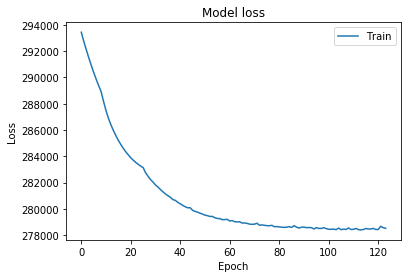

-------------------------------------------------------------------------------
/n
Strategy net profitability
3911150.6661152653
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 46.4673  ]
 [ 34.440613]
 [174.28107 ]
 [191.36539 ]
 [193.28969 ]
 [ 82.56691 ]
 [ 38.94222 ]
 [141.99405 ]
 [145.45125 ]
 [ 78.11414 ]]


In [24]:
run_whole_model_assesment(build_sigm10_sign5_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36352/36400 [============================>.] - ETA: 0s - loss: 335934.9691 - mae: 113.7350 - mse: 335935.0000
Epoch: 0, loss:335685.8435,  mae:113.7535,  mse:335685.8438,  val_loss:292258.2707,  val_mae:121.0830,  val_mse:292258.3125,  
36400/36400 [==============================] - 7s 200us/sample - loss: 335685.8435 - mae: 113.7535 - mse: 335685.8438 - val_loss: 292258.2707 - val_mae: 121.0830 - val_mse: 292258.3125
Epoch 2/1000
36400/36400 [==============================] - 7s 199us/sample - loss: 334248.3338 - mae: 119.8156 - mse: 334248.3438 - val_loss: 290935.7059 - val_mae: 126.6558 - val_mse: 290935.6250
Epoch 3/1000
36400/36400 [==============================] - 7s 187us/sample - loss: 333011.4261 - mae: 125.2617 - mse: 333011.3750 - val_loss: 289694.5998 - val_mae: 132.2851 - val_mse: 289694.7188
Epoch 4/1000
36400/36400 [==============================] - 8s 210us/sample - loss: 331848.4375 - mae: 131.0931 - mse: 3

Epoch 40/1000
36400/36400 [==============================] - 6s 174us/sample - loss: 322481.7464 - mae: 181.5982 - mse: 322481.4375 - val_loss: 279181.7009 - val_mae: 187.8802 - val_mse: 279181.6875
Epoch 41/1000
36400/36400 [==============================] - 6s 169us/sample - loss: 322400.5449 - mae: 182.4332 - mse: 322400.4062 - val_loss: 279114.0675 - val_mae: 189.2127 - val_mse: 279114.1250
Epoch 42/1000
36400/36400 [==============================] - 7s 179us/sample - loss: 322347.3466 - mae: 182.6543 - mse: 322347.4062 - val_loss: 279096.1092 - val_mae: 186.1241 - val_mse: 279096.1250
Epoch 43/1000
36400/36400 [==============================] - 7s 186us/sample - loss: 322279.3846 - mae: 183.0872 - mse: 322278.9375 - val_loss: 279115.8268 - val_mae: 184.3440 - val_mse: 279115.7188
Epoch 44/1000
36400/36400 [==============================] - 8s 228us/sample - loss: 322260.6451 - mae: 182.7845 - mse: 322260.5312 - val_loss: 278972.6431 - val_mae: 188.8584 - val_mse: 278972.7188
Epoch

36400/36400 [==============================] - 9s 238us/sample - loss: 320706.9076 - mae: 186.2995 - mse: 320707.0312 - val_loss: 278425.0663 - val_mae: 189.0343 - val_mse: 278425.0312
TRAINING ENDED


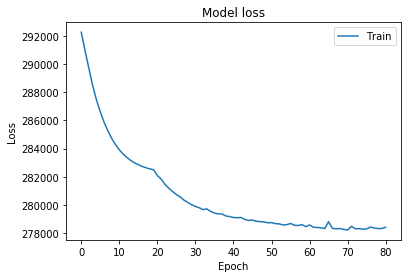

-------------------------------------------------------------------------------
/n
Strategy net profitability
3893883.5382309714
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 53.23288 ]
 [ 24.4107  ]
 [185.77122 ]
 [194.59637 ]
 [194.63202 ]
 [ 72.854126]
 [ 32.76393 ]
 [133.30882 ]
 [149.77853 ]
 [ 95.39253 ]]


In [34]:
run_whole_model_assesment(build_sigm15_relu10_sigm10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36192/36400 [============================>.] - ETA: 0s - loss: 336879.1428 - mae: 111.2910 - mse: 336879.0312
Epoch: 0, loss:336242.7259,  mae:111.3806,  mse:336242.5938,  val_loss:293025.9119,  val_mae:118.0154,  val_mse:293025.7812,  
36400/36400 [==============================] - 5s 128us/sample - loss: 336242.7259 - mae: 111.3806 - mse: 336242.5938 - val_loss: 293025.9119 - val_mae: 118.0154 - val_mse: 293025.7812
Epoch 2/1000
36400/36400 [==============================] - 7s 189us/sample - loss: 335152.0336 - mae: 115.8361 - mse: 335152.0625 - val_loss: 292055.3236 - val_mae: 121.9134 - val_mse: 292055.5000
Epoch 3/1000
36400/36400 [==============================] - 7s 202us/sample - loss: 334248.6814 - mae: 119.6846 - mse: 334248.6875 - val_loss: 291141.0854 - val_mae: 125.7641 - val_mse: 291141.2500
Epoch 4/1000
36400/36400 [==============================] - 9s 234us/sample - loss: 333416.7391 - mae: 123.4565 - mse: 3

Epoch 40/1000
36400/36400 [==============================] - 7s 197us/sample - loss: 323667.2193 - mae: 172.4724 - mse: 323667.1250 - val_loss: 280239.8737 - val_mae: 179.5492 - val_mse: 280239.8438
Epoch 41/1000
36400/36400 [==============================] - 7s 200us/sample - loss: 323549.0544 - mae: 173.3446 - mse: 323549.1875 - val_loss: 280288.3122 - val_mae: 173.3748 - val_mse: 280288.2812
Epoch 42/1000
36400/36400 [==============================] - 8s 221us/sample - loss: 323468.5108 - mae: 173.2426 - mse: 323468.3438 - val_loss: 280123.2343 - val_mae: 175.6888 - val_mse: 280123.0625
Epoch 43/1000
36400/36400 [==============================] - 7s 195us/sample - loss: 323380.0409 - mae: 174.4018 - mse: 323380.0312 - val_loss: 280025.9038 - val_mae: 177.0607 - val_mse: 280025.8438
Epoch 44/1000
36400/36400 [==============================] - 6s 152us/sample - loss: 323259.3448 - mae: 174.2505 - mse: 323259.4375 - val_loss: 279913.1055 - val_mae: 178.1454 - val_mse: 279913.0000
Epoch

36400/36400 [==============================] - 8s 232us/sample - loss: 321505.8350 - mae: 184.0742 - mse: 321505.7188 - val_loss: 278710.4866 - val_mae: 186.7220 - val_mse: 278710.6250
Epoch 82/1000
36400/36400 [==============================] - 8s 217us/sample - loss: 321489.2223 - mae: 183.3864 - mse: 321489.2500 - val_loss: 278674.2677 - val_mae: 189.5674 - val_mse: 278674.0938
Epoch 83/1000
36400/36400 [==============================] - 7s 197us/sample - loss: 321462.7899 - mae: 184.0616 - mse: 321463.0000 - val_loss: 278705.4639 - val_mae: 186.7630 - val_mse: 278705.4062
Epoch 84/1000
36400/36400 [==============================] - 7s 196us/sample - loss: 321440.1796 - mae: 183.9283 - mse: 321440.0625 - val_loss: 278592.2132 - val_mae: 192.2621 - val_mse: 278592.2812
Epoch 85/1000
36400/36400 [==============================] - 8s 212us/sample - loss: 321389.6094 - mae: 183.2518 - mse: 321389.6562 - val_loss: 278560.4004 - val_mae: 196.6109 - val_mse: 278560.4375
Epoch 86/1000
36400

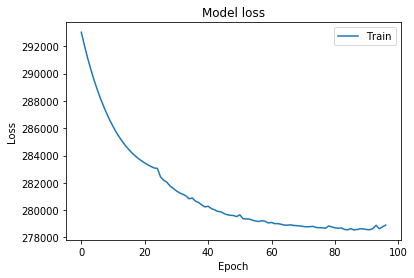

-------------------------------------------------------------------------------
/n
Strategy net profitability
3751452.224827423
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 60.479744]
 [ 25.783228]
 [158.95273 ]
 [175.5924  ]
 [175.79489 ]
 [ 65.30701 ]
 [ 36.351086]
 [138.20041 ]
 [133.28648 ]
 [ 68.42572 ]]


In [23]:
run_whole_model_assesment(build_sigm15_relu10_sigm10_lin())

Train on 36400 samples, validate on 9100 samples
Epoch 1/1000
36224/36400 [============================>.] - ETA: 0s - loss: 335381.6891 - mae: 112.3650 - mse: 335381.7812
Epoch: 0, loss:335961.9143,  mae:112.6416,  mse:335962.0000,  val_loss:292461.9826,  val_mae:120.2579,  val_mse:292461.9688,  
36400/36400 [==============================] - 6s 154us/sample - loss: 335961.9143 - mae: 112.6416 - mse: 335962.0000 - val_loss: 292461.9826 - val_mae: 120.2579 - val_mse: 292461.9688
Epoch 2/1000
36400/36400 [==============================] - 5s 137us/sample - loss: 334303.3163 - mae: 119.5133 - mse: 334303.3438 - val_loss: 290906.6929 - val_mae: 126.7826 - val_mse: 290906.7500
Epoch 3/1000
36400/36400 [==============================] - 9s 258us/sample - loss: 332956.1656 - mae: 125.6521 - mse: 332956.1562 - val_loss: 289596.3498 - val_mae: 132.7501 - val_mse: 289596.3750
Epoch 4/1000
36400/36400 [==============================] - 9s 240us/sample - loss: 331802.5546 - mae: 131.3957 - mse: 3

Epoch 40/1000
36400/36400 [==============================] - 7s 195us/sample - loss: 322308.4248 - mae: 181.2360 - mse: 322308.3125 - val_loss: 279018.5753 - val_mae: 185.8738 - val_mse: 279018.5312
Epoch 41/1000
36400/36400 [==============================] - 8s 218us/sample - loss: 322259.8126 - mae: 181.0050 - mse: 322259.8750 - val_loss: 278959.5263 - val_mae: 186.2563 - val_mse: 278959.5312
Epoch 42/1000
36400/36400 [==============================] - 8s 226us/sample - loss: 322206.1537 - mae: 181.3200 - mse: 322206.2812 - val_loss: 278907.0314 - val_mae: 186.8414 - val_mse: 278906.9688
Epoch 43/1000
36400/36400 [==============================] - 8s 209us/sample - loss: 322136.4030 - mae: 181.4518 - mse: 322136.5000 - val_loss: 278863.4481 - val_mae: 187.2189 - val_mse: 278863.3125
Epoch 44/1000
36400/36400 [==============================] - 8s 210us/sample - loss: 322097.0387 - mae: 182.5719 - mse: 322097.0312 - val_loss: 278908.3415 - val_mae: 183.2315 - val_mse: 278908.3750
Epoch

36400/36400 [==============================] - 6s 152us/sample - loss: 320374.9575 - mae: 184.2635 - mse: 320374.9375 - val_loss: 278464.6248 - val_mae: 189.0168 - val_mse: 278464.6250
Epoch 82/1000
36400/36400 [==============================] - 6s 164us/sample - loss: 320369.2842 - mae: 185.6384 - mse: 320369.1875 - val_loss: 278544.9428 - val_mae: 185.5717 - val_mse: 278545.0000
Epoch 83/1000
36400/36400 [==============================] - 9s 249us/sample - loss: 320265.5038 - mae: 184.1572 - mse: 320265.5938 - val_loss: 278393.1904 - val_mae: 192.1595 - val_mse: 278393.1562
TRAINING ENDED


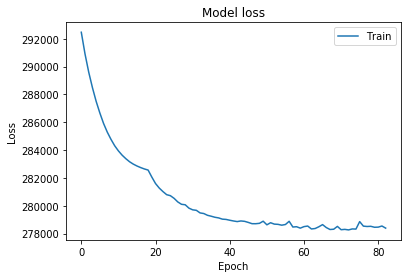

-------------------------------------------------------------------------------
/n
Strategy net profitability
3958492.9088566974
-------------------------------------------------------------------------------
/n
the first few reults of our predictions - to check they arent identical
[[ 58.663937]
 [ 19.082842]
 [198.25208 ]
 [199.59134 ]
 [199.71748 ]
 [ 81.31946 ]
 [ 36.525936]
 [157.46405 ]
 [135.9228  ]
 [ 71.21588 ]]


In [38]:
run_whole_model_assesment(build_sigm20_relu15_sigm15_lin())

In [40]:
from sklearn import linear_model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

In [41]:
print((np.abs(y_pred - y_test)).sum())

4093760.5999999996


In [60]:

from sklearn import linear_model

clf = linear_model.SGDRegressor(max_iter=1000000, tol=1e-3, loss = 'epsilon_insensitive', epsilon = 0)

In [62]:
clf.fit(x_train, y_train)
clf.predict(x_test)

0.0061876965747170234

In [ ]:
def plot_stats(hist, stat):
    #plt.plot(hist.history[stat])
    plt.plot(hist.history['val_'+stat])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [ ]:
plot_stats(history, 'mse')

In [ ]:
lin:: $ -361630.3526860428 @@ 466621.7812
tanh30, relu30 :: $-209779.9205638123 @@ 468193.0625
relu10, relu5, relu5, lin :: $-89188 @@ 


In [35]:
predictions = y_train.mean()
print((np.abs(predictions - y_test)).sum())

4105513.938911652


In [ ]:
print((predictions - y_train).sum())

In [28]:
y_train.mean()

115.98025406593463

In [32]:
y_test.mean()

103.82858461538444